In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Copy data 

In [3]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [4]:
!ls {BASE_PATH}

detect-flood-water	flood-training-metadata.csv
flood-train-images.tgz	flood-train-labels.tgz


In [5]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 268 ms, sys: 88.2 ms, total: 357 ms
Wall time: 42.3 s


In [6]:
%%time
file_name = 'flood-train-labels.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 12.5 ms, sys: 15.8 ms, total: 28.3 ms
Wall time: 542 ms


In [7]:
file_name = 'flood-training-metadata.csv'
file_path = BASE_PATH + file_name

!cp {file_path} .

# Imports

In [8]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [9]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [10]:
os.chdir("/content/drive/My Drive/ai/detect-flood-water/detect-flood-water/")

In [11]:
!pip install rasterio
!pip install pandas_path
!pip install segmentation_models_pytorch

     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 87 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
     |████████████████████████████████| 376 kB 19.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=2e989e9e0868c1b80216e5ff092d08e772284c99235529eba912f0baad7ed75b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4a79e4754f9c45a1a675b9729f86d7f6d9f5b9fefd672444122367613b27964b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [12]:
from utils import seed_everything

In [13]:
seed = 2021
seed_everything(seed)

In [ ]:
# 

# Load data 

In [14]:
from dataset import FloodDataset

In [15]:
from pathlib import Path
from pandas_path import path

In [16]:
PATH_TO_DATA = '/content/'
os.listdir(PATH_TO_DATA)

['.config',
 'flood-train-labels.tgz',
 'train_features',
 'flood-training-metadata.csv',
 'train_labels',
 'flood-train-images.tgz',
 'drive',
 'sample_data']

In [17]:
train_metadata = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'flood-training-metadata.csv'),
    parse_dates=["scene_start"]
)
train_metadata.shape

(1084, 6)

In [18]:
DATA_PATH = Path(PATH_TO_DATA)

In [19]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [20]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [21]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,/content/train_features/awc00_vh.tif,/content/train_labels/awc00.tif
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,/content/train_features/awc00_vv.tif,/content/train_labels/awc00.tif
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,/content/train_features/awc01_vh.tif,/content/train_labels/awc01.tif
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,/content/train_features/awc01_vv.tif,/content/train_labels/awc01.tif
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,/content/train_features/awc02_vh.tif,/content/train_labels/awc02.tif


# Split data

In [68]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [70]:
# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['kuo', 'tht', 'qus']

In [71]:
valid_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [72]:
# Separate features from labels
val_x = get_paths_by_chip(valid_df)
val_y = valid_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train_df)
train_y = train_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [73]:
len(val_x) / (len(val_x) + len(train_x)) * 100

23.062730627306273

# Train

In [74]:
print(f'[data] Dataset size, train: {len(train_x)}, valid: {len(val_x)}')

[data] Dataset size, train: 417, valid: 125


In [29]:
reduce_train = False
train_number = 32
valid_number = 32

if reduce_train:
    train_x = train_x.head(train_number)
    train_y = train_y.head(train_number)

    val_x = val_x.head(valid_number)
    val_y = val_y.head(valid_number)
    print(f'[data] Reduced dataset size, train: {len(train_x)}, valid: {len(val_x)}')

[data] Reduced dataset size, train: 32, valid: 32


In [75]:
train_dataset = FloodDataset(train_x, train_y, transforms=None)
valid_dataset = FloodDataset(val_x, val_y, transforms=None)

In [76]:
batch_size_train = 8
batch_size_valid = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)

In [ ]:
print(f'[data] DataLoader size, train: {len(train_loader)}, valid: {len(valid_loader)}')

In [77]:
import segmentation_models_pytorch as smp

In [78]:
encoder_name = 'resnet18'
encoder_weights = 'imagenet'

unet_model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=2,
    classes=2,
)

In [79]:
learning_rate=3e-4
weight_decay=0

optimizer = torch.optim.Adam(
    unet_model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

In [80]:
loss = nn.CrossEntropyLoss(ignore_index=255)

In [81]:
max_iter=99
valid_num=4

valid_interval=max_iter // valid_num

valid_iters=np.arange(0, max_iter, valid_interval)
valid_iters

array([ 0, 24, 48, 72, 96])

In [82]:
from train import train_model

In [83]:
unet_model = unet_model.to(device)

In [84]:
len(train_loader)

53

In [85]:
max_iter=300

In [86]:
epoch = max_iter / len(train_loader)
epoch

5.660377358490566

In [ ]:
# ['kuo', 'tht', 'qus']

In [87]:

# valid_iters=[10, 30, 60, 99]
# valid_iters=[100, 200, 300, 400, 499]
valid_iters=[50, 100, 150, 200, 250, 299]

train_info = train_model(
    model=unet_model,
    device=device,
    data_loader=train_loader,
    valid_loader=valid_loader,
    criterion=loss,
    optimizer=optimizer,
    max_iter=max_iter,
    valid_iters=valid_iters,
    verbose=True,
    print_every=5
)

[train] started...
[train] iter:   50, loss = 0.30829, score = 0.46312, time: 0:01:21
[valid] iter:   50, loss = 0.16480, score = 0.63417, time: 0:01:21

[train] iter:  100, loss = 0.25897, score = 0.52503, time: 0:02:22
[valid] iter:  100, loss = 0.11631, score = 0.66982, time: 0:02:22

[train] iter:  150, loss = 0.23719, score = 0.54776, time: 0:03:16
[valid] iter:  150, loss = 0.19526, score = 0.63175, time: 0:03:16

[train] iter:  200, loss = 0.22532, score = 0.56070, time: 0:04:10
[valid] iter:  200, loss = 0.23903, score = 0.48316, time: 0:04:10

[train] iter:  250, loss = 0.21542, score = 0.57382, time: 0:05:04
[valid] iter:  250, loss = 0.14059, score = 0.65559, time: 0:05:04

[train] iter:  299, loss = 0.20467, score = 0.59061, time: 0:05:56
[valid] iter:  299, loss = 0.19754, score = 0.55248, time: 0:05:56

[train] finished for: 0:05:56


In [64]:
# train_info

In [65]:
from plot_utils import show_trainig_results, show_loss

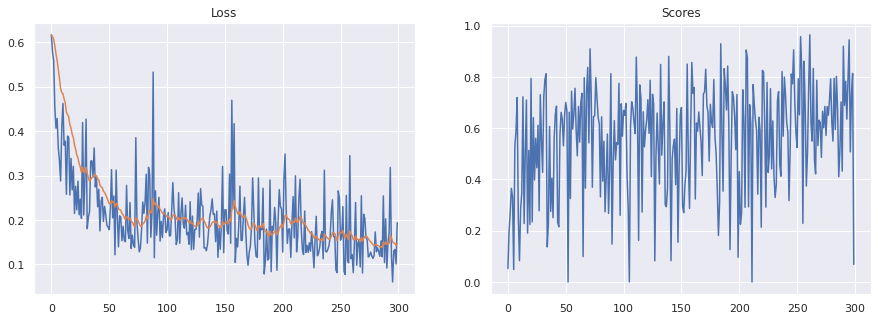

In [88]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_trainig_results(loss_meter, score_meter)

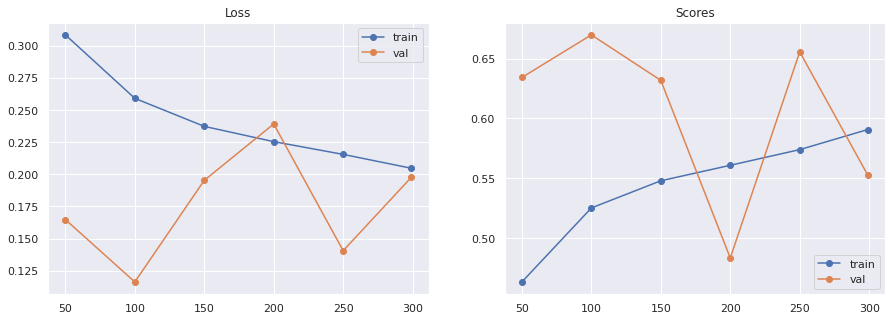

In [89]:
show_loss(train_info)